In [10]:
import numpy as np
import pandas as pd
from utils import  amplitude_scaling, load_dataset, save_distance_matrix
from sklearn.neighbors import KNeighborsClassifier
from dtaidistance import dtw
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV, cross_val_predict
from utils import dtw_dist, decode_y, top_flop_f1
from pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
import matplotlib.pyplot as plt

# Simple knn classification

### raw time series

In [2]:
X_train_raw, y_train_raw, X_test_raw, y_test_raw = load_dataset('../dataset_ts/ts_data_raw.npz')

In [3]:
# amplitude scaling
X_train_raw_scaled,y_train_raw_scaled = amplitude_scaling(X_train_raw,y_train_raw)
X_test_raw_scaled,y_test_raw_scaled = amplitude_scaling(X_test_raw,y_test_raw)

Validation

In [4]:
knn = KNeighborsClassifier(n_neighbors=1, weights='distance', n_jobs=-1, metric='euclidean')
knn.fit(X_train_raw_scaled[:6000], y_train_raw_scaled[:6000])
y_pred = knn.predict(X_train_raw_scaled[6000:])
print(classification_report(y_train_raw_scaled[6000:],y_pred))

              precision    recall  f1-score   support

           0       0.06      0.01      0.02        69
           1       0.00      0.00      0.00        66
           2       0.13      0.06      0.08        83
           3       0.30      0.37      0.33        78
           4       0.06      0.03      0.04        75
           5       0.31      0.14      0.19        74
           6       0.33      0.10      0.15        94
           7       0.14      0.07      0.09        61
           8       0.25      0.51      0.34        69
           9       0.14      0.07      0.09        83
          10       0.06      0.14      0.09        78
          11       0.06      0.11      0.08        75
          12       0.07      0.10      0.08        72
          13       0.17      0.36      0.23        72
          14       0.48      0.14      0.21        74
          15       0.21      0.05      0.09        91
          16       0.14      0.42      0.21        67
          17       0.06    

Test

In [5]:
knn = KNeighborsClassifier(n_neighbors=1, weights='distance', n_jobs=-1, metric='euclidean')
knn.fit(X_train_raw_scaled, y_train_raw_scaled)
y_pred = knn.predict(X_test_raw_scaled)
print(classification_report(y_test_raw_scaled,y_pred))

              precision    recall  f1-score   support

           0       0.30      0.10      0.15       127
           1       0.12      0.07      0.09       133
           2       0.08      0.05      0.06       109
           3       0.22      0.24      0.23       139
           4       0.04      0.02      0.02       131
           5       0.17      0.10      0.12       135
           6       0.23      0.08      0.12       116
           7       0.16      0.07      0.10       145
           8       0.31      0.57      0.40       136
           9       0.11      0.05      0.07       119
          10       0.08      0.22      0.12       125
          11       0.07      0.12      0.09       123
          12       0.09      0.09      0.09       143
          13       0.14      0.29      0.19       118
          14       0.61      0.20      0.30       128
          15       0.06      0.02      0.03       112
          16       0.08      0.22      0.12       119
          17       0.07    

### SAX-128

In [2]:
X_train_s, y_train_s, X_test_s, y_test_s = load_dataset('../dataset_ts/ts_data_sax128.npz')

In [37]:
# amplitude scaling
X_train_s_scaled,y_train_s_scaled = amplitude_scaling(X_train_s,y_train_s)
X_test_s_scaled,y_test_s_scaled = amplitude_scaling(X_test_s,y_test_s)


In [14]:
save_distance_matrix(np.concatenate((X_train_s_scaled, X_test_s_scaled), axis=0), 'distances/hugesax-16_matrices')

Model Selection:

In [38]:
euc_mat_s, dtw_mat_s = (np.load('distances/bigsax_matrices.npz')['euclidean'], np.load('distances/bigsax_matrices.npz')['dtw'])

In [39]:
train_dtw_mat_s = dtw_mat_s[:7500,:7500]
test_dtw_mat_s = dtw_mat_s[7500:,:7500]

train_euc_mat_s = euc_mat_s[:7500,:7500]
test_euc_mat_s = euc_mat_s[7500:,:7500]

In [40]:
# dtw model selection
dtw_s_t =  train_dtw_mat_s[:6000,:6000]
dtw_s_v = train_dtw_mat_s[6000:,:6000]

best_acc = 0
best_k = 0
for i in range(1,200):
    knn = KNeighborsClassifier(n_neighbors=i, metric='precomputed', weights='distance')
    knn.fit(dtw_s_t, y_train_s_scaled[:6000])
    acc = knn.score(dtw_s_v,y_train_s_scaled[6000:])
    if acc > best_acc:
        best_acc = acc
        best_k = i

print(f'Miglior numero di vicini: {best_k}, con accuracy: {best_acc}')

Miglior numero di vicini: 9, con accuracy: 0.166


In [41]:
# dtw selected model
knn = KNeighborsClassifier(n_neighbors=9, metric='precomputed', weights='distance')
knn.fit(dtw_s_t, y_train_s_scaled[:6000])
y_pred = knn.predict(dtw_s_v)
print(classification_report(y_train_s_scaled[6000:],y_pred))

              precision    recall  f1-score   support

           0       0.04      0.03      0.03        77
           1       0.09      0.06      0.07        85
           2       0.14      0.11      0.12        74
           3       0.29      0.20      0.24        69
           4       0.20      0.15      0.17        87
           5       0.21      0.09      0.12        79
           6       0.29      0.15      0.20        81
           7       0.17      0.05      0.08       100
           8       0.28      0.53      0.37        66
           9       0.07      0.06      0.07        77
          10       0.17      0.45      0.25        74
          11       0.15      0.18      0.16        62
          12       0.07      0.13      0.09        67
          13       0.28      0.25      0.27        84
          14       0.24      0.08      0.12        78
          15       0.11      0.12      0.12        59
          16       0.15      0.20      0.17        59
          17       0.13    

In [42]:
# euclidean model selection
euc_s_t =  train_euc_mat_s[:6000,:6000]
euc_s_v = train_euc_mat_s[6000:,:6000]

best_acc = 0
best_k = 0
for i in range(1,200):
    knn = KNeighborsClassifier(n_neighbors=i, metric='precomputed', weights='distance')
    knn.fit(euc_s_t, y_train_s_scaled[:6000])
    acc = knn.score(euc_s_v,y_train_s_scaled[6000:])
    if acc > best_acc:
        best_acc = acc
        best_k = i

print(f'Miglior numero di vicini: {best_k}, con accuracy: {best_acc}')

Miglior numero di vicini: 5, con accuracy: 0.12066666666666667


Test:

In [43]:
# dtw test
knn = KNeighborsClassifier(n_neighbors=9, metric='precomputed', weights='distance')
knn.fit(train_dtw_mat_s, y_train_s_scaled)
y_pred = knn.predict(test_dtw_mat_s)
print(classification_report(y_test_s_scaled,y_pred))

              precision    recall  f1-score   support

           0       0.13      0.07      0.09       125
           1       0.05      0.04      0.04       125
           2       0.06      0.04      0.05       125
           3       0.32      0.24      0.28       125
           4       0.11      0.11      0.11       125
           5       0.07      0.04      0.05       125
           6       0.15      0.08      0.10       125
           7       0.13      0.07      0.09       125
           8       0.43      0.62      0.51       125
           9       0.10      0.10      0.10       125
          10       0.14      0.36      0.21       125
          11       0.12      0.12      0.12       125
          12       0.09      0.16      0.12       125
          13       0.21      0.25      0.23       125
          14       0.12      0.03      0.05       125
          15       0.16      0.08      0.11       125
          16       0.18      0.22      0.20       125
          17       0.08    

In [44]:
# euclidean test
knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed', weights='distance')
knn.fit(train_euc_mat_s, y_train_s_scaled)
y_pred = knn.predict(test_euc_mat_s)
print(classification_report(y_test_s_scaled,y_pred))

              precision    recall  f1-score   support

           0       0.20      0.10      0.13       125
           1       0.10      0.06      0.08       125
           2       0.09      0.04      0.05       125
           3       0.12      0.25      0.16       125
           4       0.04      0.02      0.02       125
           5       0.19      0.08      0.11       125
           6       0.21      0.10      0.13       125
           7       0.17      0.07      0.10       125
           8       0.29      0.59      0.39       125
           9       0.06      0.03      0.04       125
          10       0.07      0.16      0.10       125
          11       0.05      0.07      0.06       125
          12       0.05      0.05      0.05       125
          13       0.13      0.29      0.18       125
          14       0.18      0.05      0.08       125
          15       0.13      0.04      0.06       125
          16       0.10      0.24      0.14       125
          17       0.05    

### PAA-128

In [2]:
X_train_paa, y_train_paa, X_test_paa, y_test_paa, enc_dict = load_dataset('../dataset_ts/ts_data_paa128.npz')

In [3]:
# amplitude scaling
#X_train_paa_scaled,y_train_paa_scaled = amplitude_scaling(X_train_paa,y_train_paa)
#X_test_paa_scaled,y_test_paa_scaled = amplitude_scaling(X_test_paa,y_test_paa)

X_train_paa_scaled = np.squeeze(X_train_paa)
X_test_paa_scaled = np.squeeze(X_test_paa)
y_train_paa_scaled = y_train_paa
y_test_paa_scaled = y_test_paa
y_train_dec = decode_y(y_train_paa_scaled, enc_dict)
y_test_dec = decode_y(y_test_paa_scaled, enc_dict)

In [11]:
save_distance_matrix(np.concatenate((X_train_paa_scaled, X_test_paa_scaled), axis=0), 'distances/paa_matrices_unscaled')

Model Selection:

In [4]:
euc_mat_paa, dtw_mat_paa = (np.load('distances/paa_matrices_unscaled.npz')['euclidean'], np.load('distances/paa_matrices_unscaled.npz')['dtw'])

In [5]:
train_dtw_mat_paa = dtw_mat_paa[:7500,:7500]
test_dtw_mat_paa = dtw_mat_paa[7500:,:7500]

train_euc_mat_paa = euc_mat_paa[:7500,:7500]
test_euc_mat_paa = euc_mat_paa[7500:,:7500]

In [6]:
dtw_paa_t =  train_dtw_mat_paa[:6000,:6000]
dtw_paa_v = train_dtw_mat_paa[6000:,:6000]

In [8]:
# dtw model selection

best_acc = 0
best_k = 0
for i in range(1,200):
    knn = KNeighborsClassifier(n_neighbors=i, metric='precomputed', weights='distance')
    knn.fit(dtw_paa_t, y_train_paa_scaled[:6000])
    acc = knn.score(dtw_paa_v,y_train_paa_scaled[6000:])
    if acc > best_acc:
        best_acc = acc
        best_k = i

print(f'Miglior numero di vicini: {best_k}, con accuracy: {best_acc}')


Miglior numero di vicini: 31, con accuracy: 0.2653333333333333


                   precision    recall  f1-score   support

              emo       0.22      0.03      0.05        77
             folk       0.20      0.11      0.14        85
             goth       0.13      0.09      0.11        74
            happy       0.39      0.42      0.40        69
      heavy-metal       0.20      0.61      0.31        87
       honky-tonk       0.20      0.37      0.26        79
           j-idol       0.23      0.35      0.28        81
             kids       0.59      0.10      0.17       100
   minimal-techno       0.44      0.35      0.39        66
              mpb       0.12      0.06      0.09        77
          new-age       0.47      0.62      0.53        74
            opera       0.18      0.24      0.20        62
            piano       0.63      0.46      0.53        67
progressive-house       0.55      0.13      0.21        84
            salsa       0.20      0.21      0.20        78
        sertanejo       0.16      0.37      0.22       

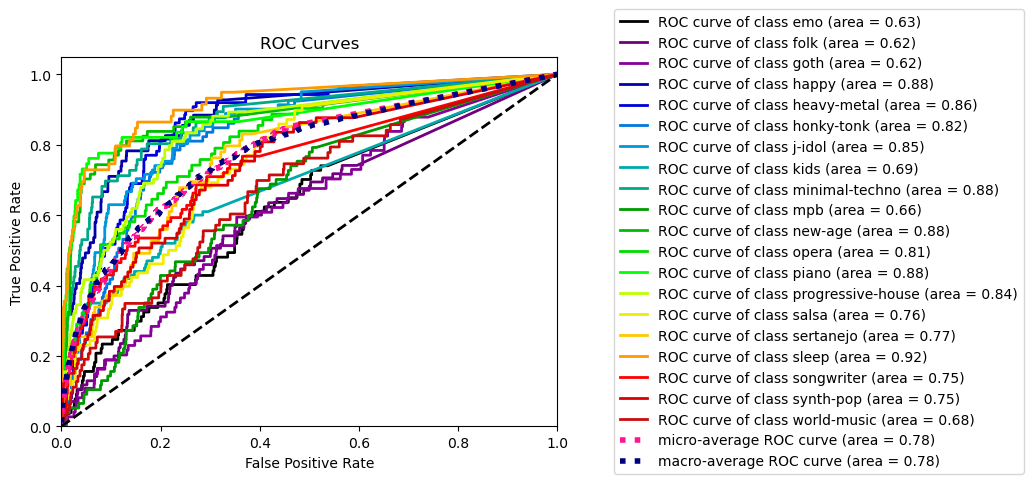

TOP 5 F1-SCORE:
new-age: 0.5348837209302325
piano: 0.5344827586206896
sleep: 0.4857142857142857
happy: 0.4027777777777778
minimal-techno: 0.3898305084745763


FLOP 5 F1-SCORE:
emo: 0.046511627906976744
mpb: 0.08547008547008547
goth: 0.109375
world-music: 0.11023622047244094
folk: 0.13846153846153847


In [12]:
# dtw selected model
knn = KNeighborsClassifier(n_neighbors=31, metric='precomputed', weights='distance')
knn.fit(dtw_paa_t, y_train_paa_scaled[:6000])
y_pred = knn.predict(dtw_paa_v)
y_pred_proba = knn.predict_proba(dtw_paa_v)
print(classification_report(y_train_dec[6000:],decode_y(y_pred, enc_dict)))

plot_roc(y_train_dec[6000:], y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(y_train_dec[6000:], decode_y(y_pred, enc_dict))

In [14]:
euc_paa_t =  train_euc_mat_paa[:6000,:6000]
euc_paa_v = train_euc_mat_paa[6000:,:6000]

In [10]:
# euclidean model selection


best_acc = 0
best_k = 0
for i in range(1,200):
    knn = KNeighborsClassifier(n_neighbors=i, metric='precomputed', weights='distance')
    knn.fit(euc_paa_t, y_train_paa_scaled[:6000])
    acc = knn.score(euc_paa_v,y_train_paa_scaled[6000:])
    if acc > best_acc:
        best_acc = acc
        best_k = i

print(f'Miglior numero di vicini: {best_k}, con accuracy: {best_acc}')

Miglior numero di vicini: 111, con accuracy: 0.16666666666666666


c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                   precision    recall  f1-score   support

              emo       0.00      0.00      0.00        77
             folk       0.00      0.00      0.00        85
             goth       0.07      0.03      0.04        74
            happy       0.32      0.39      0.35        69
      heavy-metal       0.12      0.76      0.21        87
       honky-tonk       0.09      0.01      0.02        79
           j-idol       0.14      0.16      0.15        81
             kids       0.00      0.00      0.00       100
   minimal-techno       0.67      0.03      0.06        66
              mpb       0.00      0.00      0.00        77
          new-age       0.35      0.64      0.45        74
            opera       0.12      0.44      0.18        62
            piano       0.63      0.48      0.54        67
progressive-house       0.57      0.05      0.09        84
            salsa       0.00      0.00      0.00        78
        sertanejo       1.00      0.02      0.03       

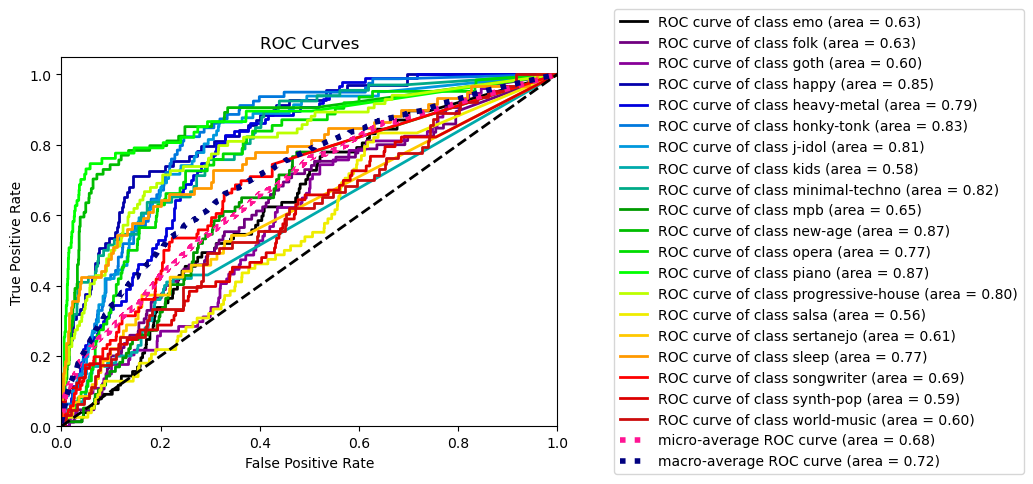

TOP 5 F1-SCORE:
piano: 0.5423728813559322
new-age: 0.45410628019323673
happy: 0.35064935064935066
heavy-metal: 0.21256038647342995
opera: 0.1836734693877551


FLOP 5 F1-SCORE:
emo: 0.0
folk: 0.0
kids: 0.0
mpb: 0.0
salsa: 0.0


In [15]:
# euclidean selected model
knn = KNeighborsClassifier(n_neighbors=111, metric='precomputed', weights='distance')
knn.fit(euc_paa_t, y_train_paa_scaled[:6000])
y_pred = knn.predict(euc_paa_v)
y_pred_proba = knn.predict_proba(euc_paa_v)
print(classification_report(y_train_dec[6000:],decode_y(y_pred, enc_dict)))

plot_roc(y_train_dec[6000:], y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(y_train_dec[6000:], decode_y(y_pred, enc_dict))

Test:

In [11]:
# dtw test
knn = KNeighborsClassifier(n_neighbors=31, metric='precomputed', weights='distance')
knn.fit(train_dtw_mat_paa, y_train_paa_scaled)
y_pred = knn.predict(test_dtw_mat_paa)
print(classification_report(y_test_paa_scaled,y_pred))

              precision    recall  f1-score   support

           0       0.33      0.05      0.08       125
           1       0.06      0.03      0.04       125
           2       0.07      0.06      0.07       125
           3       0.42      0.43      0.43       125
           4       0.18      0.56      0.27       125
           5       0.22      0.42      0.29       125
           6       0.23      0.42      0.30       125
           7       0.44      0.09      0.15       125
           8       0.61      0.42      0.50       125
           9       0.11      0.04      0.06       125
          10       0.40      0.54      0.46       125
          11       0.30      0.37      0.33       125
          12       0.57      0.44      0.50       125
          13       0.50      0.18      0.26       125
          14       0.13      0.16      0.14       125
          15       0.22      0.34      0.27       125
          16       0.52      0.65      0.57       125
          17       0.31    

In [12]:
# euclidean test
knn = KNeighborsClassifier(n_neighbors=111, metric='precomputed', weights='distance')
knn.fit(train_euc_mat_paa, y_train_paa_scaled)
y_pred = knn.predict(test_euc_mat_paa)
print(classification_report(y_test_paa_scaled,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.03      0.06       125
           1       0.06      0.01      0.01       125
           2       0.00      0.00      0.00       125
           3       0.37      0.27      0.31       125
           4       0.10      0.70      0.18       125
           5       0.17      0.02      0.03       125
           6       0.14      0.21      0.17       125
           7       1.00      0.01      0.02       125
           8       0.71      0.04      0.08       125
           9       0.50      0.01      0.02       125
          10       0.29      0.52      0.37       125
          11       0.17      0.44      0.24       125
          12       0.54      0.44      0.48       125
          13       0.63      0.10      0.17       125
          14       0.00      0.00      0.00       125
          15       1.00      0.01      0.02       125
          16       0.10      0.51      0.17       125
          17       0.00    

c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### SAX-32

In [2]:
X_train_sax, y_train_sax, X_test_sax, y_test_sax = load_dataset('../dataset_ts/ts_data_sax32.npz')

In [3]:
# amplitude scaling
X_train_sax_scaled,y_train_sax_scaled = amplitude_scaling(X_train_sax,y_train_sax)
X_test_sax_scaled,y_test_sax_scaled = amplitude_scaling(X_test_sax,y_test_sax)

In [49]:
#save_distance_matrix(np.concatenate((X_train_sax_scaled, X_test_sax_scaled), axis=0), 'distances/sax_matrices')

euclidean calcolata


In [50]:
euc_mat_sax, dtw_mat_sax = (np.load('distances/sax_matrices.npz')['euclidean'], np.load('distances/sax_matrices.npz')['dtw'])

Model Selection:

In [51]:
train_dtw_mat_sax = dtw_mat_sax[:7500,:7500]
test_dtw_mat_sax = dtw_mat_sax[7500:,:7500]

train_euc_mat_sax = euc_mat_sax[:7500,:7500]
test_euc_mat_sax = euc_mat_sax[7500:,:7500]

In [53]:
# dtw model selection
dtw_sax_t =  train_dtw_mat_sax[:6000,:6000]
dtw_sax_v = train_dtw_mat_sax[6000:,:6000]

best_acc = 0
best_k = 0
for i in range(1,200):
    knn = KNeighborsClassifier(n_neighbors=i, metric='precomputed', weights='distance')
    knn.fit(dtw_sax_t, y_train_sax_scaled[:6000])
    acc = knn.score(dtw_sax_v,y_train_sax_scaled[6000:])
    if acc > best_acc:
        best_acc = acc
        best_k = i

print(f'Miglior numero di vicini: {best_k}, con accuracy: {best_acc}')


Miglior numero di vicini: 10, con accuracy: 0.12133333333333333


In [54]:
# euclidean model selection
euc_sax_t =  train_euc_mat_sax[:6000,:6000]
euc_sax_v = train_euc_mat_sax[6000:,:6000]

best_acc = 0
best_k = 0
for i in range(1,200):
    knn = KNeighborsClassifier(n_neighbors=i, metric='precomputed', weights='distance')
    knn.fit(euc_sax_t, y_train_sax_scaled[:6000])
    acc = knn.score(euc_sax_v,y_train_sax_scaled[6000:])
    if acc > best_acc:
        best_acc = acc
        best_k = i

print(f'Miglior numero di vicini: {best_k}, con accuracy: {best_acc}')

Miglior numero di vicini: 8, con accuracy: 0.11933333333333333


Test:

In [55]:
# dtw test
knn = KNeighborsClassifier(n_neighbors=10, metric='precomputed', weights='distance')
knn.fit(train_dtw_mat_sax, y_train_sax_scaled)
y_pred = knn.predict(test_dtw_mat_sax)
print(classification_report(y_test_sax_scaled,y_pred))

              precision    recall  f1-score   support

           0       0.07      0.05      0.06       127
           1       0.06      0.05      0.06       133
           2       0.06      0.06      0.06       109
           3       0.18      0.21      0.19       139
           4       0.08      0.05      0.06       131
           5       0.10      0.07      0.08       135
           6       0.10      0.10      0.10       116
           7       0.08      0.03      0.05       145
           8       0.20      0.21      0.21       136
           9       0.07      0.06      0.06       119
          10       0.09      0.13      0.10       125
          11       0.08      0.09      0.08       123
          12       0.05      0.04      0.04       143
          13       0.15      0.22      0.18       118
          14       0.08      0.06      0.07       128
          15       0.05      0.05      0.05       112
          16       0.13      0.21      0.16       119
          17       0.09    

In [56]:
# euclidean test
knn = KNeighborsClassifier(n_neighbors=8, metric='precomputed', weights='distance')
knn.fit(train_euc_mat_sax, y_train_sax_scaled)
y_pred = knn.predict(test_euc_mat_sax)
print(classification_report(y_test_sax_scaled,y_pred))

              precision    recall  f1-score   support

           0       0.11      0.06      0.08       127
           1       0.07      0.05      0.06       133
           2       0.03      0.03      0.03       109
           3       0.13      0.22      0.16       139
           4       0.06      0.04      0.05       131
           5       0.13      0.10      0.12       135
           6       0.13      0.12      0.12       116
           7       0.09      0.04      0.06       145
           8       0.14      0.35      0.20       136
           9       0.07      0.03      0.04       119
          10       0.10      0.11      0.11       125
          11       0.02      0.02      0.02       123
          12       0.05      0.03      0.04       143
          13       0.11      0.25      0.15       118
          14       0.14      0.08      0.10       128
          15       0.10      0.07      0.08       112
          16       0.08      0.13      0.10       119
          17       0.10    

In [5]:
len([8,3,13,18,5,6,10,14,16,19,17,0,15,1,7,4,9,12,2,11])

20

In [13]:
# prova
pip = Pipeline([8,3,13,18,5,6,10,14,16,19,17,0,15,1,7,4,9,12,2,11])
pip.fit(X_train_sax_scaled[:6000], y_train_sax_scaled[:6000], resampling_ratio=0.1)
y_pred = pip.predict(X_train_sax_scaled[6000:])
print(classification_report(y_train_sax_scaled[6000:],y_pred, zero_division=0))

2
(array([0, 1]), array([302, 308], dtype=int64))
              precision    recall  f1-score   support

           0       0.17      0.06      0.09        69
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00        83
           3       0.16      0.36      0.22        78
           4       0.17      0.01      0.02        75
           5       0.07      0.16      0.10        74
           6       0.08      0.13      0.10        94
           7       0.17      0.02      0.03        61
           8       0.17      0.42      0.25        69
           9       0.00      0.00      0.00        83
          10       0.06      0.13      0.09        78
          11       0.00      0.00      0.00        75
          12       0.00      0.00      0.00        72
          13       0.10      0.28      0.14        72
          14       0.10      0.09      0.10        74
          15       0.13      0.02      0.04        91
          16       0.11      0.